In [1]:
import os
import pandas as pd
import numpy as np
import glob
import datetime

desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 10)

In [2]:
##############################################################################
# Load and clean Rating data                                                 #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\Rating.csv'
df_ratings_raw = pd.read_csv(path)

# drop RatingSPOutlook,RatingSPOutlook columns
df_ratings_no_xtra_col = df_ratings_raw.drop(columns=['RatingSPOutlook', 'RatingSPOutlook.1'])

# drop NA from RatingSP column
df_ratings_clean = df_ratings_no_xtra_col.dropna(subset=['RatingSP'])

# calculate mean per security by removing KeyDate
df_ratings_clean = df_ratings_clean.drop(columns=['KeyDate'])
df_ratings_with_mean = df_ratings_clean.groupby(['SecurityID']).mean()
df_ratings_with_mean.reset_index()

,SecurityID,RatingSP
0,64,10.000000
1,72,13.000000
2,78,14.652361
3,82,15.000000
4,83,14.652361
...,...,...
17918,72406,14.000000
17919,72407,14.000000
17920,72504,17.000000
17921,72675,8.000000


In [3]:
##############################################################################
# Load and clean Spreads data                                                #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\raw_data_files'
all_files = glob.glob(os.path.join(path, "*.csv"))  # use os.path.join to make concat OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True, sort=False)

In [4]:
# drop na from spreads data
df_merged = df_merged.dropna(how='any')
# convert dates to Date type
df_merged['KeyDate'] = pd.to_datetime(df_merged['KeyDate'], errors='coerce')

# Extract the low liers
dates_low_liers = df_merged["KeyDate"].value_counts()
dates_low_liers = dates_low_liers[dates_low_liers < 500]

# clean the dataset by removing the low liers and NaNs
df_merged_clean = df_merged[~df_merged['KeyDate'].isin(dates_low_liers.index)]

# drop rows after March 1st 2020
indexDates = df_merged_clean[ df_merged_clean['KeyDate'] > '2020-03-01' ].index
df_merged_clean.drop(indexDates , inplace=True)

# drop KeyDate column
df_data_values = df_merged_clean.drop(columns=['KeyDate'])

# group by security and average all other columns
df_data_values_with_mean = df_data_values.groupby(['SecurityID']).mean()
df_data_values_with_mean.reset_index()

,SecurityID,Price,YieldWorst,ModifiedDuration_Plain,AmtOutstanding,GSpread,OAS_Spread,ZSpread,AswUsd
0,64,101.030416,4.575854,5.818073,1.697266e+09,266.128523,197.627440,264.103364,260.005244
1,72,107.733566,3.865144,3.404476,1.000000e+09,200.229956,196.899290,197.525862,203.728448
2,78,104.120369,2.916503,2.028475,8.000000e+08,103.426473,100.203312,96.953608,98.470406
3,82,114.694976,4.529194,14.953470,2.000000e+09,206.578273,204.865876,234.248454,251.878175
4,83,106.988634,2.832795,1.290010,1.000000e+09,91.194434,85.292228,78.617851,82.453120
...,...,...,...,...,...,...,...,...,...
18991,69103,120.005077,3.621411,16.009238,4.000000e+08,177.669743,173.741538,206.576846,229.194846
18992,69106,105.056692,3.792591,7.517122,3.000000e+08,251.457062,197.909769,251.098154,255.227846
18993,69109,100.917769,7.092544,5.953214,1.000000e+09,567.398154,553.436462,575.944769,569.686231
18994,69114,98.928192,4.664027,6.617713,7.500000e+08,324.435303,268.741385,332.940846,324.974231


In [5]:
##############################################################################
# Load and clean Securities meta data                                        #
##############################################################################
path = r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\SecurityData.csv'  # use your path
df_securities = pd.read_csv(path)

# filter out CountryDomicile=US
df_securities_US = df_securities.loc[df_securities['CountryDomicile'] == 'US']

In [6]:
##############################################################################
# Merge all the datasets into one DataFrame / File                           #
##############################################################################

# left join RatingSP from df_rating on df_securities and replace NA with zero
df_securities_US_w_avg_rating = df_securities_US.merge(df_ratings_with_mean, on=['SecurityID'], how='left')
df_securities_US_w_avg_rating['RatingSP'] = df_securities_US_w_avg_rating['RatingSP'].fillna(0)

# left join all columns by SecurityID from df_avg_data_values into df_securities_US_w_avg_rating
df_securities_US_w_data = df_securities_US_w_avg_rating.merge(df_data_values_with_mean, on=['SecurityID'], how='left')

# drop rows from df_securities_US_w_data without average spreads
df_securities_US_w_data_clean = df_securities_US_w_data.dropna(subset=['Price', 'YieldWorst', 'ModifiedDuration_Plain',
                                                                       'AmtOutstanding', 'GSpread', 'OAS_Spread', 'ZSpread', 'AswUsd'])
# Load Time Series engineered features from file 
df_US_TimeSeries_metrics = pd.read_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\Time-Series-Features-US-Securites.csv')

# left join to the main clean df 
df_securities_US_w_data_clean = df_securities_US_w_data_clean.merge(df_US_TimeSeries_metrics, on=['SecurityID'], how='left')

# df_securities_US_w_data_clean['Test Statistics'] = df_securities_US_w_data_clean['Test Statistics'].fillna(0)
# df_securities_US_w_data_clean['p-value'] = df_securities_US_w_data_clean['p-value'].fillna(0)
# df_securities_US_w_data_clean['No. of lags used'] = df_securities_US_w_data_clean['No. of lags used'].fillna(0)
# df_securities_US_w_data_clean['Number of observations used'] = df_securities_US_w_data_clean['Number of observations used'].fillna(0)
# df_securities_US_w_data_clean['critical value (1%)'] = df_securities_US_w_data_clean['critical value (1%)'].fillna(0)
# df_securities_US_w_data_clean['critical value (5%)'] = df_securities_US_w_data_clean['critical value (5%)'].fillna(0)
# df_securities_US_w_data_clean['critical value (10%)'] = df_securities_US_w_data_clean['critical value (10%)'].fillna(0)


In [7]:
# Bring in Landis' time series features 

df_US_TimeSeries_metrics_II = pd.read_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\time_series_features_II.csv')
df_securities_US_w_data_clean = df_securities_US_w_data_clean.merge(df_US_TimeSeries_metrics_II, on=['SecurityID'], how='left')

df_securities_US_w_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11634 entries, 0 to 11633
Data columns (total 90 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SecurityID                   11634 non-null  int64  
 1   OfficialName                 11634 non-null  object 
 2   SecurityType                 11634 non-null  object 
 3   SecuritySubType              11634 non-null  object 
 4   SecurityBBGType              11634 non-null  object 
 5   SecurityBBGYellowKey         11634 non-null  object 
 6   Series                       500 non-null    object 
 7   SecuritySector               11634 non-null  object 
 8   SecurityIndustry             11634 non-null  object 
 9   SecuritySubIndustry          11634 non-null  object 
 10  BBGSecuritySector            11634 non-null  object 
 11  IssuerParent                 11634 non-null  object 
 12  Obligor                      11629 non-null  object 
 13  Ticker          

In [8]:
df_securities_US_w_data_clean.fillna(value=0, inplace=True)

# TEMP - output df_securities to US_Securities_with_AVG_Rating_AVG_Spreads.csv
df_securities_US_w_data_clean.to_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\US_Securities_with_AVG_Rating_AVG_Spreads.csv')

In [9]:
# df_securities_US_w_data_clean['coef'] = df_securities_US_w_data_clean['coef'].fillna(0)
# df_securities_US_w_data_clean['intercept'] = df_securities_US_w_data_clean['intercept'].fillna(0)
# df_securities_US_w_data_clean['m_trend'] = df_securities_US_w_data_clean['m_trend'].fillna(0)
# df_securities_US_w_data_clean['m_seasonal'] = df_securities_US_w_data_clean['m_seasonal'].fillna(0)
# df_securities_US_w_data_clean['kurtosis'] = df_securities_US_w_data_clean['kurtosis'].fillna(0)
# df_securities_US_w_data_clean['skewness'] = df_securities_US_w_data_clean['skewness'].fillna(0)
# df_securities_US_w_data_clean['mean'] = df_securities_US_w_data_clean['mean'].fillna(0)
# df_securities_US_w_data_clean['p'] = df_securities_US_w_data_clean['p'].fillna(0)
# df_securities_US_w_data_clean['q'] = df_securities_US_w_data_clean['q'].fillna(0)
# df_securities_US_w_data_clean['v_mu'] = df_securities_US_w_data_clean['v_mu'].fillna(0)
# df_securities_US_w_data_clean['omega'] = df_securities_US_w_data_clean['omega'].fillna(0)
# df_securities_US_w_data_clean['alpha1'] = df_securities_US_w_data_clean['alpha1'].fillna(0)
# df_securities_US_w_data_clean['alpha2'] = df_securities_US_w_data_clean['alpha2'].fillna(0)
# df_securities_US_w_data_clean['beta1'] = df_securities_US_w_data_clean['beta1'].fillna(0)
# df_securities_US_w_data_clean['beta2'] = df_securities_US_w_data_clean['beta2'].fillna(0)

In [10]:
df_securities_US_w_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11634 entries, 0 to 11633
Data columns (total 90 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SecurityID                   11634 non-null  int64  
 1   OfficialName                 11634 non-null  object 
 2   SecurityType                 11634 non-null  object 
 3   SecuritySubType              11634 non-null  object 
 4   SecurityBBGType              11634 non-null  object 
 5   SecurityBBGYellowKey         11634 non-null  object 
 6   Series                       11634 non-null  object 
 7   SecuritySector               11634 non-null  object 
 8   SecurityIndustry             11634 non-null  object 
 9   SecuritySubIndustry          11634 non-null  object 
 10  BBGSecuritySector            11634 non-null  object 
 11  IssuerParent                 11634 non-null  object 
 12  Obligor                      11634 non-null  object 
 13  Ticker          

In [11]:
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from scipy.spatial.distance import cdist

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time

%matplotlib inline

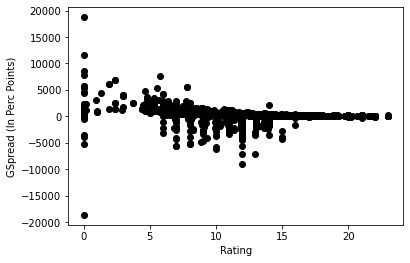

In [12]:
X = df_securities_US_w_data_clean[["RatingSP","GSpread"]]
#Visualise data points
plt.scatter(X["RatingSP"],X["GSpread"],c='black')
plt.xlabel('Rating')
plt.ylabel('GSpread (In Perc Points)')
plt.show()

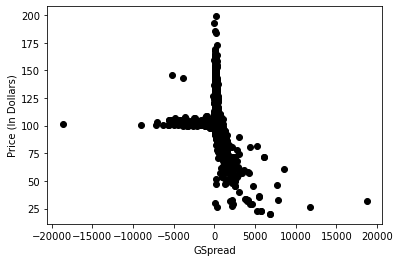

In [13]:
X = df_securities_US_w_data_clean[["GSpread","Price"]]
#Visualise data points
plt.scatter(X["GSpread"],X["Price"],c='black')
plt.xlabel('GSpread')
plt.ylabel('Price (In Dollars)')
plt.show()

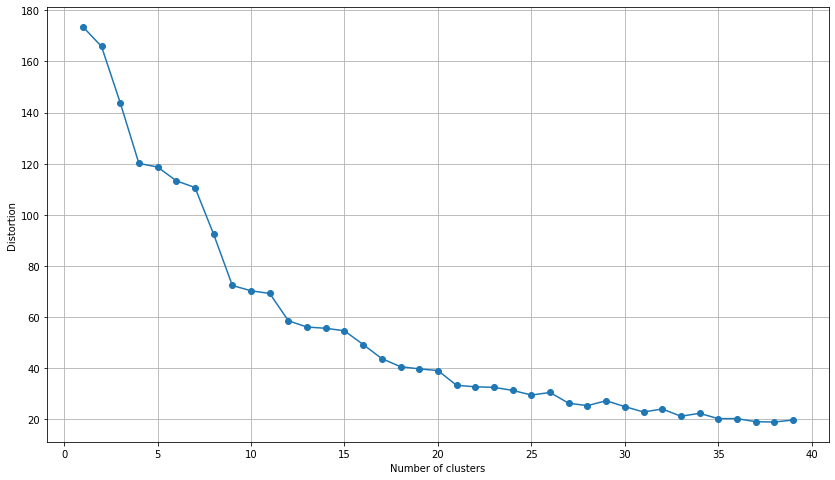

In [35]:
K = range(1,40)
df = df_securities_US_w_data_clean[['GSpread'
#                                     'RatingSP',
#                                     'YieldWorst',
#                                     'Price'
#                                     'AmtOutstanding',
#                                     'OAS_Spread',
#                                     'ZSpread',
#                                     'AswUsd',
#                                     'AmountIssued',
#                                     'Test Statistics',
#                                     'No. of lags used',
#                                     'Number of observations used',
#                                     'critical value (1%)',
#                                     'critical value (5%)',
#                                     'critical value (10%)',
#                                     'kurtosis',
#                                     'coef',
#                                     'intercept',
#                                     'm_trend',
#                                     'm_seasonal',
#                                     'skewness',
#                                     'mean', 
#                                     'v_mu',
#                                     'omega',
#                                     'p',
#                                     'q'
#                                     'alpha1',
#                                     'alpha2',
#                                     'beta1',
#                                     'beta2'
                                   ]]

distortions = []
for k in K:
    km = KMeans(
        n_clusters=k, init='k-means++',
        n_init=30, max_iter=500, random_state=42
    ).fit(df)
    km.fit(df)
    distortions.append(sum(np.min(cdist(df, km.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])


plt.figure(figsize=(14,8))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')    
plt.plot(K, distortions, marker='o')
plt.grid()
plt.show()


In [36]:
kmeans = KMeans(n_clusters=15, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df)
centroids_gspread = kmeans.cluster_centers_
inertias_gspread = kmeans.inertia_
print(centroids_gspread)
print(inertias_gspread)


[[   251.29843036    108.053548  ]
 [ -1746.32983239    102.31633395]
 [  4638.71759983     41.89073215]
 [  1219.03544031     82.68613678]
 [ -4665.73032814    106.68199351]
 [ 11695.10665843     26.36272857]
 [-18667.69259975    101.491375  ]
 [    92.77356911    106.45857333]
 [   608.76367559     96.59078982]
 [  -739.02998896    101.79128258]
 [ 18751.981486       32.125     ]
 [  2404.05569379     59.36966936]
 [  7128.79621641     46.16295145]
 [ -2913.22164469    102.72362663]
 [ -7397.81361689    101.09285937]]
101473563.30786821


In [37]:
preds = kmeans.fit_predict(df)
print(len(preds))

# df_securities_US_w_data_clean
df_test = df_securities_US_w_data_clean.copy()

df_test['ClusterTag'] = pd.Series(preds, index=df_test.index)
df_test.to_csv(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\df_test.csv')

11634


[[   251.29843036    108.053548  ]
 [ -1746.32983239    102.31633395]
 [  4638.71759983     41.89073215]
 [  1219.03544031     82.68613678]
 [ -4665.73032814    106.68199351]
 [ 11695.10665843     26.36272857]
 [-18667.69259975    101.491375  ]
 [    92.77356911    106.45857333]
 [   608.76367559     96.59078982]
 [  -739.02998896    101.79128258]
 [ 18751.981486       32.125     ]
 [  2404.05569379     59.36966936]
 [  7128.79621641     46.16295145]
 [ -2913.22164469    102.72362663]
 [ -7397.81361689    101.09285937]]
101473563.30786821


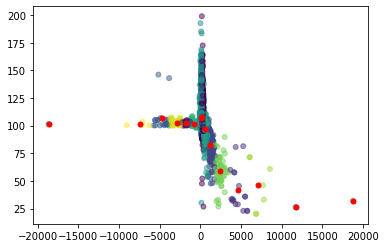

In [38]:
# Visualization only
df_2 = df[['GSpread', 'Price']]

kmeans2 = KMeans(n_clusters=15, init='k-means++', max_iter=500, n_init=30, verbose=False, random_state=42).fit(df_2)
centroids_kmeans2 = kmeans2.cluster_centers_
inertias_kmeans2 = kmeans2.inertia_
print(centroids_kmeans2)
print(inertias_kmeans2)

plt.scatter(df_2['GSpread'], df_2['Price'], c= kmeans2.labels_.astype(float), s=25, alpha=0.5)
plt.scatter(centroids_kmeans2[:, 0], centroids_kmeans2[:, 1], c='red', s=25)
plt.show()

[[ 1.10668628e+02  1.57443285e+01]
 [ 2.67962407e+03  4.93461159e+00]
 [-3.04713971e+03  1.04603863e+01]
 [ 1.08439183e+03  6.98208404e+00]
 [ 1.52235441e+04  0.00000000e+00]
 [-1.86676926e+04  0.00000000e+00]
 [ 3.70457047e+02  1.07838292e+01]
 [-1.16545074e+03  1.08948215e+01]
 [-5.87147848e+03  8.91154691e+00]
 [ 6.15202663e+03  2.68356051e+00]]
229198573.03562412


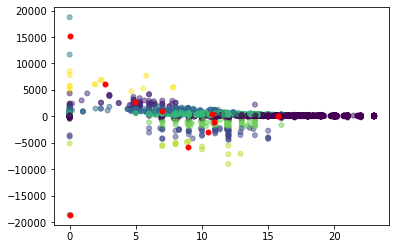

In [18]:
# Visualization only
df_3 = df[['GSpread', 'RatingSP']]

kmeans3 = KMeans(n_clusters=10, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df_3)
centroids_kmeans3 = kmeans3.cluster_centers_
inertias_kmeans3 = kmeans3.inertia_
print(centroids_kmeans3)
print(inertias_kmeans3)

plt.scatter(df_3['RatingSP'], df_3['GSpread'], c= kmeans3.labels_.astype(float), s=25, alpha=0.5)
plt.scatter(centroids_kmeans3[:, 1], centroids_kmeans3[:, 0], c='red', s=25)
plt.show()

In [39]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 


K = range(1,40)

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=500, 
               n_init=30, verbose=False, random_state=42).fit(df) 
    kmeanModel.fit(df)     
      
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

    

In [40]:
# Tabulate the different values of Distortion
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 173.57102108349116
2 : 165.82921678083338
3 : 143.83439306383943
4 : 120.09341098666047
5 : 118.67125882322166
6 : 113.29388276763505
7 : 110.66774850624353
8 : 92.36791919719428
9 : 72.34413741991038
10 : 70.27404050269928
11 : 69.22466719087889
12 : 58.535887596515906
13 : 56.080946344569945
14 : 55.607016454882626
15 : 54.61324072017709
16 : 49.24737596298426
17 : 43.726900262371544
18 : 40.58329043855343
19 : 39.729590631147204
20 : 39.05880728819701
21 : 33.30729467436233
22 : 32.71700669163681
23 : 32.507052232165925
24 : 31.31028631834185
25 : 29.497313812962943
26 : 30.4901135658817
27 : 26.273991419794015
28 : 25.354494515522298
29 : 27.258514443568174
30 : 24.97550878127672
31 : 22.857523441084865
32 : 24.04045243698056
33 : 21.212441813541272
34 : 22.344431961229983
35 : 20.255520053938973
36 : 20.281792902865572
37 : 19.05841710015633
38 : 18.93563395589839
39 : 19.72740567408197


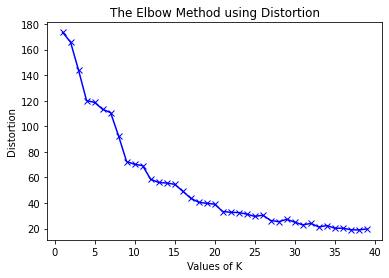

In [41]:
# Visualize the different values of Distortion
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [42]:
# Tabulate the different values of Inertia
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 3656055418.1809964
2 : 2455642079.2869954
3 : 1491975221.7678914
4 : 1088808909.1064887
5 : 846223571.9230776
6 : 669049548.2193153
7 : 488897278.3862928
8 : 356981367.1653906
9 : 290369089.0927427
10 : 230445187.89113563
11 : 191177988.3574663
12 : 157677032.3120138
13 : 129378457.40124199
14 : 114692206.34953094
15 : 101473563.30786821
16 : 87711023.71025836
17 : 74887049.535399
18 : 64182787.87979097
19 : 53757143.69257079
20 : 47717736.76413361
21 : 42119111.92292561
22 : 38719823.54549665
23 : 35059114.79056765
24 : 31875323.288881768
25 : 29330707.29067884
26 : 27124846.963167086
27 : 25203424.406559434
28 : 22662935.559910916
29 : 20976254.81161796
30 : 19610564.40030922
31 : 18087831.487139985
32 : 16924640.14023735
33 : 15633772.678811787
34 : 14849527.864586407
35 : 14064108.245029707
36 : 13444926.381852562
37 : 12706677.0818469
38 : 12049804.58010864
39 : 11419141.087949067


In [43]:
# Visualize the different values of Inertia
# plt.plot(K, inertias, 'bx-') 
# plt.xlabel('Values of K') 
# plt.ylabel('Inertia') 
# plt.title('The Elbow Method using Inertia') 
# plt.show() 

# installed on conda ---->>>>>>     conda install -c anaconda pandas-profiling


In [25]:
from pandas_profiling import ProfileReport 
prof = ProfileReport(df_securities_US_w_data_clean)
prof.to_file(r'C:\Users\mbrag\PycharmProjects\RPIA-Capstone\ProfileReport.html')
#to_file(output_file="fifa_pandas_profiling.html")

C:\Users\mbrag\AppData\Roaming\Python\Python37\site-packages\pandas_profiling\visualisation\plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
